# 14 - Aventuras na Covariâncias

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel  # Just work in < python3.9 

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [6]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    #scale_x = n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    #scale_y = n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
def draw_ellipse(mu, sigma, level, plot_points=None):
    
    fig, ax_nstd = plt.subplots(figsize=(17, 8))

    dependency_nstd = sigma.tolist()

    scale = 5, 5

    x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
    
    if plot_points is not None:
        ax_nstd.scatter(plot_points[:, 0], plot_points[:, 1], s=25)

    for l in level:
        confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

    # ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
    ax_nstd.set_title('Cafés sampled - Figure 14.2')
    ax_nstd.set_xlabel('intercepts (a_cafe)')
    ax_nstd.set_ylabel('slopes (b_cafe)')
    
    ax_nstd.set_xlim(1.8, 6.2)
    ax_nstd.set_ylim(-1.9, -0.51)
    
    plt.show()

## 14.1 Varing Slopes by Contructions

### R Code 14.1

In [8]:
a = 3.5        # Average morning wait time
b = (-1)       # Average difference afternoon wait time
sigma_a = 1    # std dev in intercepts
sigma_b = 0.5  # std in slopes
rho = (-0.7)   # correlation between intercepts and slopes

### R Code 14.2

In [9]:
Mu = np.array([a, b])  # Vector
Mu

array([ 3.5, -1. ])

 ### R Code 14.3

The matrix variance and covariance:

$$ 
\begin{pmatrix}
\mbox{variance of intercepts} & \mbox{covariance of intercepts & Slopes} \\
\mbox{covariance of intercepts & Slopes} & \mbox{variance of slopes}
\end{pmatrix}
$$

And in math form:


$$
\begin{pmatrix}
\sigma^2_\alpha & \sigma_\alpha\sigma_\beta\rho \\
\sigma_\alpha\sigma_\beta\rho & \sigma^2_\beta
\end{pmatrix}
$$

### R Code 14.3

In [10]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.matrix([
    [sigma_a**2, cov_ab],
    [cov_ab, sigma_b**2]
])
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

### R Code 14.4

In [11]:
np.matrix([[1,2], [3, 4]])

matrix([[1, 2],
        [3, 4]])

### R Code 14.5

In [12]:
sigmas = np.array([sigma_a, sigma_b])  # Standart Deviations

sigmas

array([1. , 0.5])

In [13]:
Rho = np.matrix([
    [1, rho],
    [rho, 1]
])  # Correlation Matrix

Rho

matrix([[ 1. , -0.7],
        [-0.7,  1. ]])

In [14]:
# Multiply to get covariance matrix
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)

Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

### R Code 14.6

In [15]:
N_cafe = 20

### R Code 14.7

In [16]:
np.random.seed(5)   # used to replicate example

vary_effects = stats.multivariate_normal(mean=Mu, cov=Sigma).rvs(N_cafe)
vary_effects

array([[ 3.02149593, -0.9304358 ],
       [ 1.05666673, -0.12762876],
       [ 3.58546284, -0.46432203],
       [ 4.3297356 , -1.53991745],
       [ 3.27332508, -1.02933771],
       [ 4.65859716, -1.5303893 ],
       [ 3.93018946, -0.9524405 ],
       [ 5.06625508, -1.869279  ],
       [ 2.58529637,  0.0287956 ],
       [ 5.07890482, -1.39033508],
       [ 4.36801698, -1.65042937],
       [ 4.31342478, -1.47263713],
       [ 2.59854231, -0.38835499],
       [ 3.39670791, -1.09000246],
       [ 3.48373345, -1.03170127],
       [ 2.63542057, -0.88644913],
       [ 3.49374238, -1.03389681],
       [ 3.58250316, -0.94285315],
       [ 3.46768242, -0.50699357],
       [ 3.77789108, -0.54770738]])

### R Code 14.8

In [17]:
a_cafe = vary_effects[:, 0]  # Intercepts samples
b_cafe = vary_effects[:, 1]  # Slopes samples

### R Code 14.9

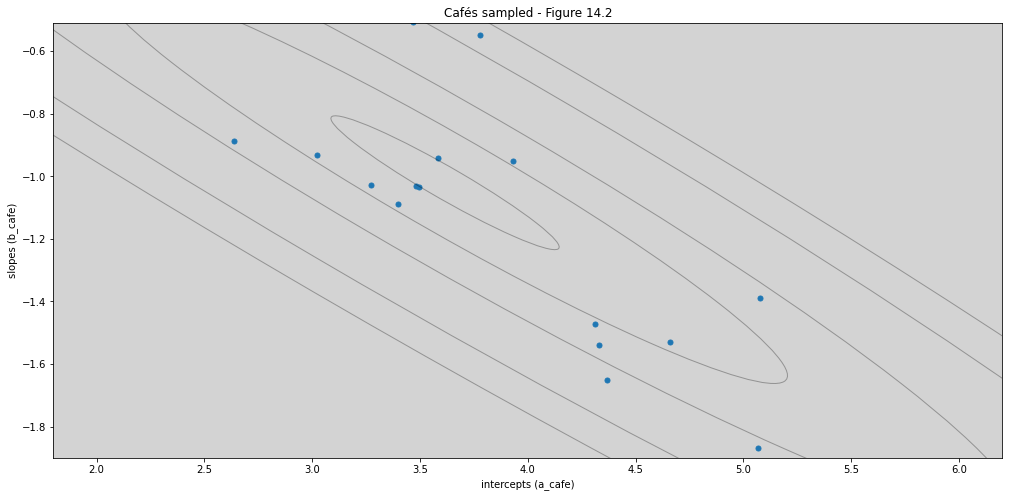

In [18]:
levels = [0.1, 0.3, 0.5, 0.8, 0.99]
draw_ellipse(mu=Mu, sigma=Sigma, level=levels, plot_points=vary_effects)

**Overthinking**: We define the *covariance* with 3 parameters: (pag 440)

 1. Firt variable standart deviations  $\sigma_\alpha$
 2. Second variable standart deviations  $ \sigma_\beta $
 3. Correlation between two variables  $\rho_{\alpha\beta}$
    
Whu the covariance is equal to $\sigma_\alpha \sigma_\beta \rho_{\alpha\beta}$?

The usual definition of the covariance between two variables $x$ and $y$ is:

$$ cov(x, y) = \mathbb{E}(xy) - \mathbb{E}(x)\mathbb{E}(y) $$


To simple variance this concept is the same:

$$ var(x) = cov(x, x) = \mathbb{E}(x^2) - \mathbb{E}(x)^2$$


If the variable with only mean equal zero ($0$), then the variance to be:

$$ var(x) = cov(x) = \mathbb{E}(x^2), \mbox{ if the } \mathbb{E}(x) = 0 $$


The correlation live in $[-1, 1]$, this is only the covariance rescaled. To be rescaled covariance just:

$$ cov(xy) = \sqrt{var(x)var(y)} \rho_{xy} $$

or better:

$$ cov(xy) = \sigma_x \sigma_y \rho_{xy} $$


### R Code 14.10

In [19]:
N_visit = 10

afternoon = np.tile([0, 1], reps=int((N_visit*N_cafe)/2))
cafe_id = np.repeat(np.arange(0, N_cafe), N_visit)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(mu, sigma, size=N_visit*N_cafe)
cafe_id += 1  # index from 1 to 20 cafe_id, need to Stan index

d = pd.DataFrame({'cafe': cafe_id, 'afternoon':afternoon, 'wait': wait})
d

,cafe,afternoon,wait
0,1,0,2.713830
1,1,1,1.965617
2,1,0,3.261427
3,1,1,2.836598
4,1,0,3.105162
...,...,...,...
195,20,1,4.001264
196,20,0,3.991292
197,20,1,2.764103
198,20,0,3.507337


## 14.1.3 The varing slope model

The likelihood:

$$ W_i \sim Normal(\mu_i, \sigma) $$

and the linear model:

$$ \mu_i = \alpha_{CAFÉ[i]} + \beta_{CAFÉ[i]}A_i $$


Then comes the matrix of varing intercepts and slopes, with it's covariance matrix:

Population of varying effects:
$$
\begin{bmatrix}
\alpha_{CAFÉ} \\
\beta_{CAFÉ}
\end{bmatrix} 
\sim Normal
\begin{pmatrix}
\begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}, S
\end{pmatrix}
$$

construct covariance matrix:

$$S = 
\begin{pmatrix} 
\sigma_\alpha &  0 \\
0  & \sigma_\beta
\end{pmatrix}
R
\begin{pmatrix} 
\sigma_\alpha &  0 \\
0  & \sigma_\beta
\end{pmatrix}
$$

The $R$ is the correlation matrix. In this simple case $R$ is defined like:

$$
R = 
\begin{pmatrix}
1 & \rho  \\
\rho & 1
\end{pmatrix}
$$


And the priors and hyper-priors:

- prior for intercept:

$$ \alpha \sim Normal(5, 2) $$


- prior for average slope:

$$ \beta \sim Normal(-1, 0.5) $$



- prior for stddev within cafés

$$\sigma \sim Exponential(1) $$


- prior for stddev among cafés

$$ \sigma_\alpha \sim Exponential(1) $$


- prior for stddev among slopes

$$ \sigma_\beta \sim Exponential(1) $$

- prior for correlation  matrix

$$ R \sim LKJcorr(2) $$

### R Code 14.11

In [20]:
# Dont have the function LKJcorr implemented in numpy or scipy
# Stan implementation - https://mc-stan.org/docs/functions-reference/lkj-correlation.html

### R Code 14.12

In [21]:
# https://mc-stan.org/docs/stan-users-guide/multivariate-hierarchical-priors.html

model = """
    data {
        int N;
        int N_cafe;
        int N_periods;
        
        array[N] real wait;
        array[N] int cafe;
        array[N] int afternoon; 
    }
    
    parameters {
        real<lower=0> sigma;
        vector<lower=0>[2] sigma_cafe;
        
        vector[N_cafe] alpha_cafe;
        vector[N_cafe] beta_cafe;
        
        real alpha;  // Like bar_alpha (hyper-prior)
        real beta;   // Like bar_beta (hyper-prior)
        
        corr_matrix[N_periods] Rho;
    }
    
    model {
        vector[N] mu;
        vector[2] Y_cafe[N_cafe];
        vector[2] MU_cafe;
        
        //(sigma) - Prior to likelihood
        sigma ~ exponential(1);  
        
        
        // (sigma_cafe) - Hyper Prior
        sigma_cafe ~ exponential(1);
        
        // (Rho) - Hyper Prior
        Rho ~ lkj_corr(2);
        
        // (MU_cafe) - Hyper Prior
        alpha ~ normal(5, 2);
        beta ~ normal(-1, 0.5);
  
        MU_cafe = [alpha, beta]';
        
        // (alpha_cafe, beta_cafe) - Prior 
        for (j in 1:N_cafe){
            Y_cafe[j] = [alpha_cafe[j], beta_cafe[j]]' ; 
        }
        
        Y_cafe ~ multi_normal(MU_cafe, quad_form_diag(Rho, sigma_cafe));  // Prior to alpha_cafe and beta_cafe
    
    
        // (mu) - Linear model
        for (i in 1:N){
            mu[i] = alpha_cafe[ cafe[i] ] + beta_cafe[ cafe[i] ] * afternoon[i];
        }
        
        // Likelihood 
        wait ~ normal(mu, sigma);
    }
"""

dat_list = {
    'N': len(d),
    'N_cafe': N_cafe,
    'N_periods': len(d.afternoon.unique()),
    'wait':  d.wait.values,
    'afternoon': d.afternoon.values,
    'cafe': d.cafe.values,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_983splkk/model_pfhxzmx3.stan', line 27, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_983splkk/model_pfhxzmx3.stan', line 38, column 8: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  1

In [22]:
model_another_way = """
    data {
        int N;
        int N_cafe;
        int N_periods;
        
        array[N] real wait;
        array[N] int cafe;
        array[N] int afternoon; 
    }
    
    parameters {
        real<lower=0> sigma;
        vector<lower=0>[2] sigma_cafe;
        
        vector[N_cafe] alpha_cafe;
        vector[N_cafe] beta_cafe;
        
        real alpha;  // Like bar_alpha (hyper-prior)
        real beta;   // Like bar_beta (hyper-prior)
        
        corr_matrix[N_periods] Rho;
    }
    
    model {
        vector[N] mu;
        
        //(sigma) - Prior to likelihood
        sigma ~ exponential(1);  
        
        
        // (sigma_cafe) - Hyper Prior
        sigma_cafe ~ exponential(1);
        
        // (Rho) - Hyper Prior
        Rho ~ lkj_corr(2);
        
        // (MU_cafe) - Hyper Prior
        alpha ~ normal(5, 2);
        beta ~ normal(-1, 0.5);

        for (i in 1:N_cafe){
            [alpha_cafe[i], beta_cafe[i]]' ~ multi_normal([alpha, beta]', quad_form_diag(Rho, sigma_cafe));
        }
        
    
        // (mu) - Linear model
        for (i in 1:N){
            mu[i] = alpha_cafe[ cafe[i] ] + beta_cafe[ cafe[i] ] * afternoon[i];
        }
        
        // Likelihood 
        wait ~ normal(mu, sigma);
    }
"""

In [23]:
m14_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [24]:
az.summary(m14_1, hdi_prob=0.89)

/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.494,0.028,0.447,0.536,0.000,0.000,4005.0,2910.0,1.0
sigma_cafe[0],0.962,0.164,0.723,1.210,0.003,0.002,3548.0,3185.0,1.0
sigma_cafe[1],0.458,0.109,0.290,0.630,0.002,0.002,2117.0,1969.0,1.0
alpha_cafe[0],2.944,0.202,2.620,3.265,0.003,0.002,4856.0,3053.0,1.0
alpha_cafe[1],1.104,0.213,0.747,1.433,0.003,0.002,4705.0,3311.0,1.0
alpha_cafe[2],3.708,0.207,3.377,4.037,0.003,0.002,4403.0,3198.0,1.0
alpha_cafe[3],4.155,0.203,3.831,4.469,0.003,0.002,5211.0,3306.0,1.0
alpha_cafe[4],3.302,0.203,2.965,3.613,0.003,0.002,5258.0,3193.0,1.0
alpha_cafe[5],4.838,0.207,4.507,5.164,0.003,0.002,5317.0,2781.0,1.0
alpha_cafe[6],4.262,0.205,3.955,4.609,0.003,0.002,4662.0,3014.0,1.0


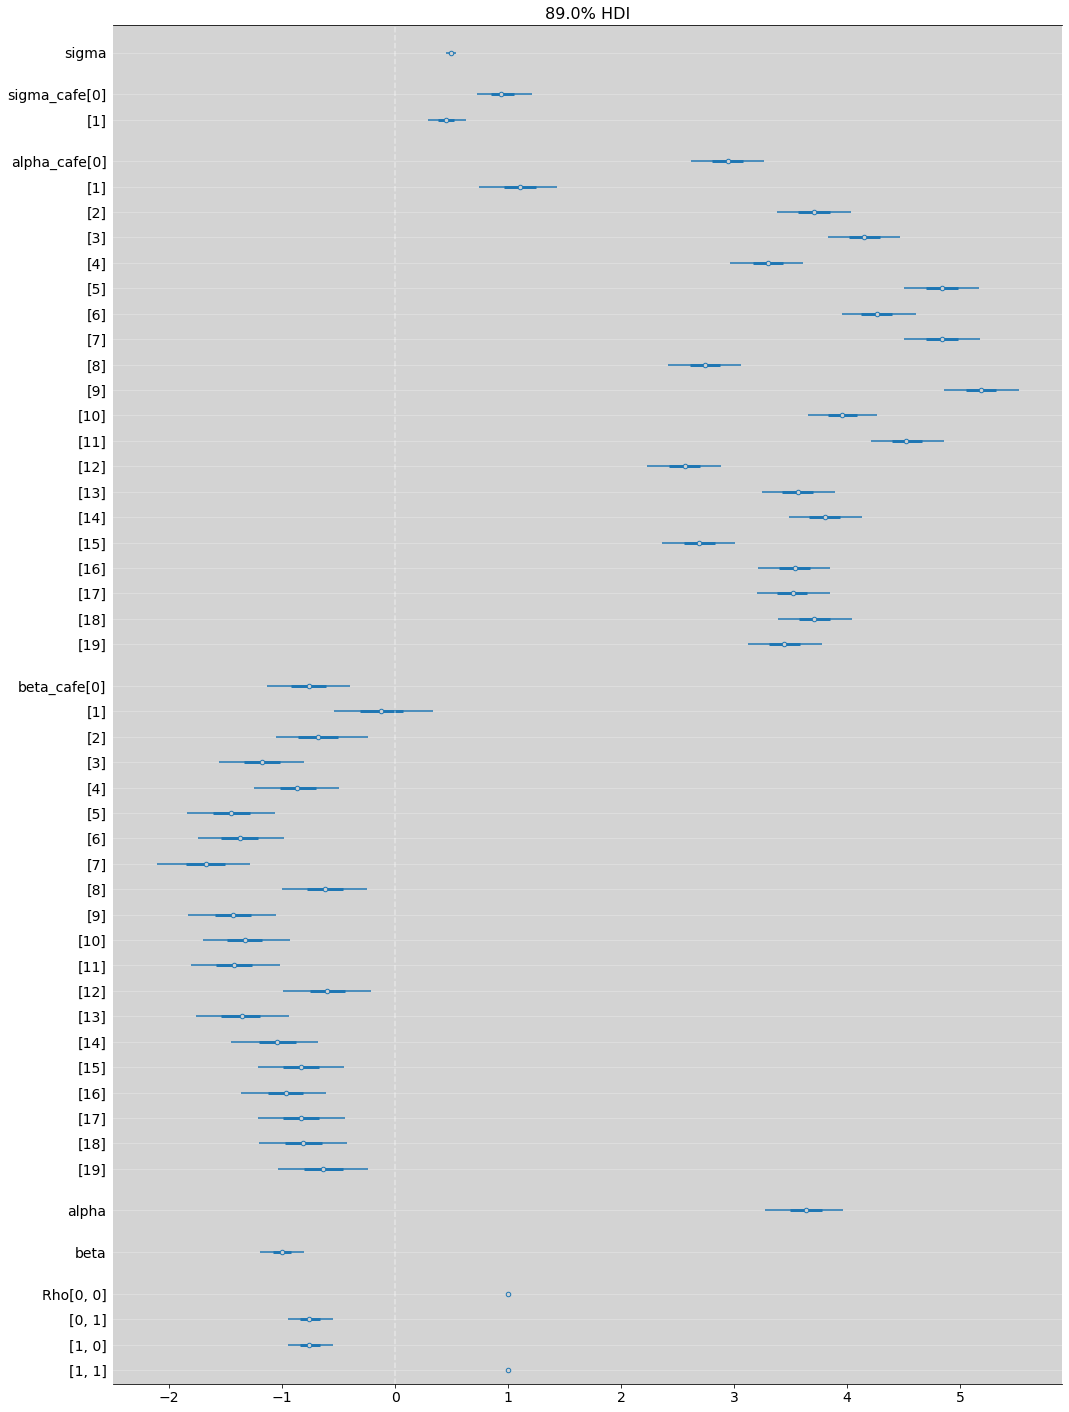

In [25]:
az.plot_forest(m14_1, hdi_prob=0.89, combined=True, figsize=(17, 25))
plt.grid(axis='y', color='white', alpha=0.3)
plt.axvline(x=0, ls='--', color='white', alpha=0.4)
plt.show()

### R Code 14.13

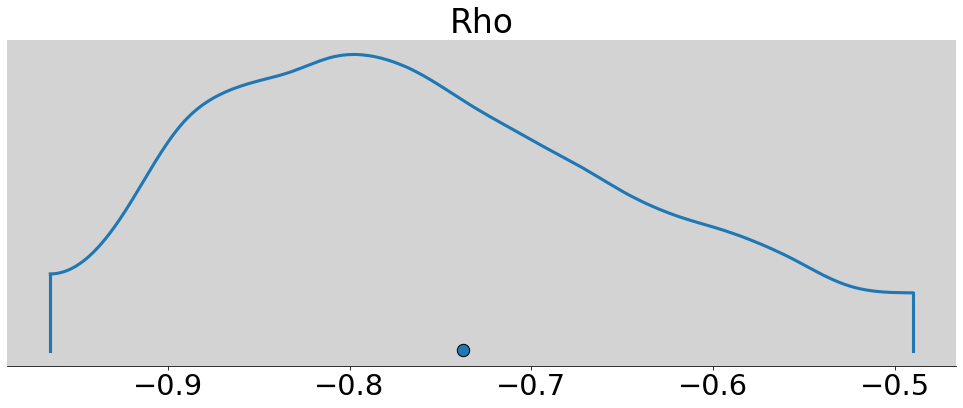

In [26]:
az.plot_density(m14_1.posterior.Rho.sel(Rho_dim_0=0, Rho_dim_1=1), figsize=(17, 6))
plt.xlabel = 'Correlation'
plt.ylabel = 'Density'
plt.show()

### R Code 14.14 & R Code 14.15

In [27]:
post_alpha = m14_1.posterior.alpha.mean().values
post_beta = m14_1.posterior.beta.mean().values

post_sigma_alpha = m14_1.posterior.sigma_cafe.sel(sigma_cafe_dim_0=0).mean().values
post_sigma_beta = m14_1.posterior.sigma_cafe.sel(sigma_cafe_dim_0=1).mean().values
post_rho = m14_1.posterior.Rho.sel(Rho_dim_0=0, Rho_dim_1=1).mean().values

print('Posterior alpha:', post_alpha)
print('Posterior beta:', post_beta)
print('Posterior sigma alpha:', post_sigma_alpha)
print('Posterior sigma beta:', post_sigma_beta)
print('Posterior Rho:', post_rho)

Posterior alpha: 3.635729554763166
Posterior beta: -1.0044396032829837
Posterior sigma alpha: 0.9615322598199262
Posterior sigma beta: 0.4579085316729445
Posterior Rho: -0.7378038268038144


In [28]:
post_matrix_sigma_alpha_beta = np.matrix([[post_sigma_alpha, 0],[0, post_sigma_beta]])
post_matrix_sigma_alpha_beta

matrix([[0.96153226, 0.        ],
        [0.        , 0.45790853]])

In [29]:
post_matrix_rho = np.matrix([[1, post_rho],[post_rho, 1]])
post_matrix_rho

matrix([[ 1.        , -0.73780383],
        [-0.73780383,  1.        ]])

In [30]:
post_Sigma = post_matrix_sigma_alpha_beta * post_matrix_rho * post_matrix_sigma_alpha_beta
post_Sigma

matrix([[ 0.92454429, -0.32485047],
        [-0.32485047,  0.20968022]])

In [31]:
a1 = [d.loc[(d['afternoon'] == 0) & (d['cafe'] == i)]['wait'].mean() for i in range(1, N_cafe+1)]
b1 = [d.loc[(d['afternoon'] == 1) & (d['cafe'] == i)]['wait'].mean() for i in range(1, N_cafe+1)]

# Remember that in R Code 14.1 above, the data is build as
# a = 3.5        # Average morning wait time
# b = (-1)       # Average difference afternoon wait time
# because this, b value is b - a, like this

b1 = [b1[i] - a1[i] for i in range(len(a1))]

In [32]:
# Extract posterior means of partially polled estimates
a2 = [m14_1.posterior.alpha_cafe.sel(alpha_cafe_dim_0=i).mean().values for i in range(N_cafe)]
b2 = [m14_1.posterior.beta_cafe.sel(beta_cafe_dim_0=i).mean().values for i in range(N_cafe)]

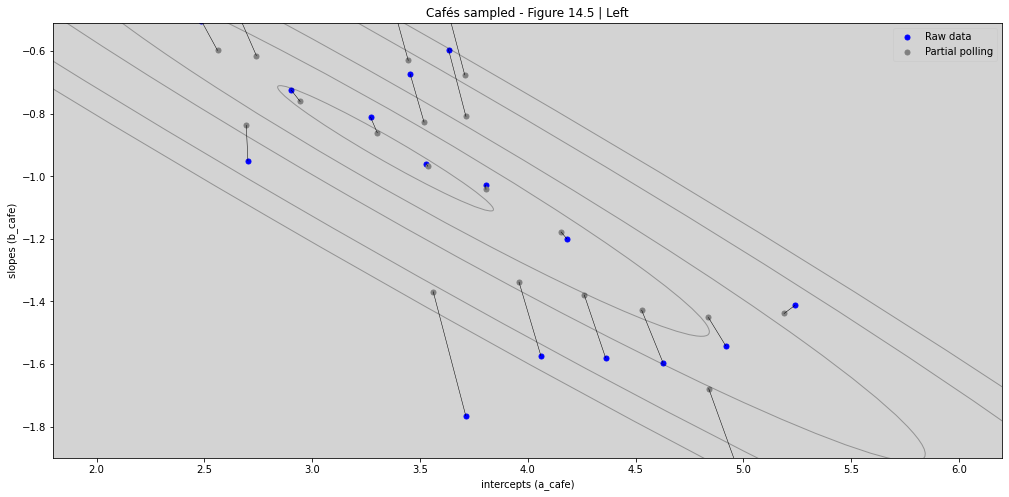

In [33]:
fig, ax_nstd = plt.subplots(figsize=(17, 8))

mu = np.array([post_alpha, post_beta])
dependency_nstd = post_Sigma.tolist()

scale = 5, 5

level = [0.1, 0.3, 0.5, 0.8, 0.99]

x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)


ax_nstd.scatter(a1, b1, s=25, color='b')
ax_nstd.scatter(a2, b2, s=25, facecolor='gray')

ax_nstd.plot([a1, a2], [b1, b2], 'k-', linewidth=0.5)
    

for l in level:
    confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

# ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Cafés sampled - Figure 14.5 | Left')
ax_nstd.set_xlabel('intercepts (a_cafe)')
ax_nstd.set_ylabel('slopes (b_cafe)')


ax_nstd.set_xlim(1.8, 6.2)
ax_nstd.set_ylim(-1.9, -0.51)

# ax_nstd.legend()
ax_nstd.legend(['Raw data', 'Partial polling'])

plt.plot(1,2, c='r')

plt.show()

### R Code 14.16 & R Code 14.17

In [34]:
wait_morning_1 = (a1)
wait_afternoon_1 = [sum(x) for x in zip(a1, b1)]
wait_morning_2 = (a2)
wait_afternoon_2 = [sum(x) for x in zip(a2, b2)]

In [35]:
# now shrinkage distribution by simulation  

v = np.random.multivariate_normal(mu ,post_Sigma, 1000)
v[:, 1] = [sum(x) for x in v]  # calculation afternoon wait
Sigma_est2 = np.cov(v[:, 0], v[:, 1])

mu_est2 = [0, 0]  # Empty vector mu
mu_est2[0] = mu[0] 
mu_est2[1] = mu[0] + mu[1]

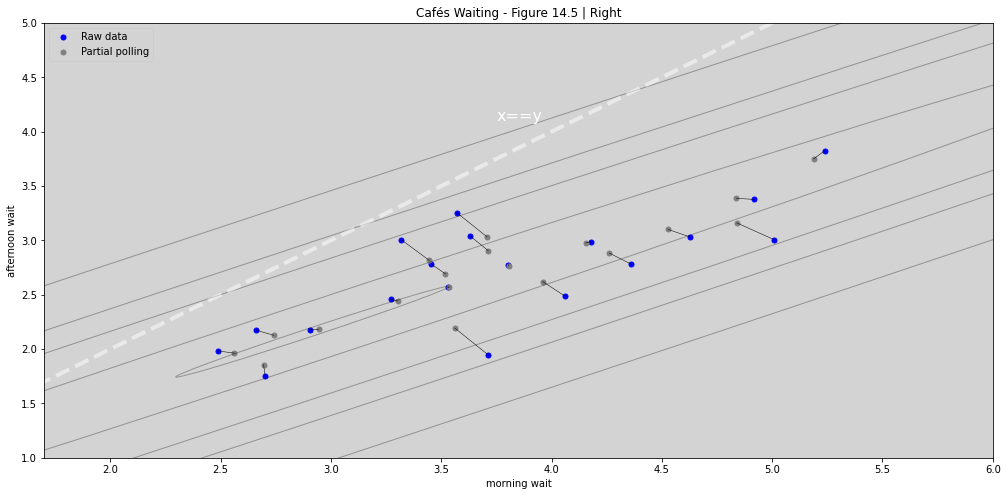

In [36]:
fig, ax_nstd = plt.subplots(figsize=(17, 8))

scale = 5, 5
#level = [0.1, 0.3, 0.5, 0.8, 0.99]
level = [0.1, 0.69, 1.5, 2.0, 3.0]

dependency_nstd = Sigma_est2.tolist()
x, y = get_correlated_dataset(500, dependency_nstd, mu_est2, scale)

ax_nstd.scatter(wait_morning_1, wait_afternoon_1, s=25, color='b')
ax_nstd.scatter(wait_morning_2, wait_afternoon_2, s=25, facecolor='gray')

ax_nstd.plot([wait_morning_1, wait_morning_2],
             [wait_afternoon_1, wait_afternoon_2], 
             'k-', linewidth=0.5)

for l in level:
    confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

ax_nstd.set_title('Cafés Waiting - Figure 14.5 | Right')
ax_nstd.set_xlabel('morning wait')
ax_nstd.set_ylabel('afternoon wait')

ax_nstd.plot([0, 10], [0, 10], ls='--', color='white', alpha=0.5, linewidth=4)
ax_nstd.text(3.75, 4.1, "x==y",color='white', fontsize=16)

ax_nstd.set_xlim(1.7, 6)
ax_nstd.set_ylim(1, 5)

# ax_nstd.legend()
ax_nstd.legend(['Raw data', 'Partial polling'])

plt.plot(1,2, c='r')

plt.show()

## 14.2 Advanced varing Slopes

### R Code 14.18

In [37]:
# Previous chimpanzees models is in chapter 11

df = pd.read_csv('./data/chimpanzees.csv', sep=';')

In [38]:
# Build the treatment data
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']  
df.head(20)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2
5,1,NaN,0,1,12,1,1,1,2
6,1,NaN,0,2,14,1,0,0,2
7,1,NaN,0,2,16,1,0,0,2
8,1,NaN,0,2,18,0,1,0,1
9,1,NaN,0,2,20,0,1,0,1


In [39]:
df.tail(20)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
484,7,2.0,1,3,34,0,0,1,3
485,7,3.0,1,3,36,1,1,1,4
486,7,7.0,1,4,38,0,0,1,3
487,7,2.0,1,4,40,0,0,1,3
488,7,4.0,1,4,42,1,1,1,4
489,7,5.0,1,4,44,0,0,1,3
490,7,6.0,1,4,46,0,0,1,3
491,7,3.0,1,4,48,0,0,1,3
492,7,5.0,1,5,50,1,1,1,4
493,7,4.0,1,5,52,0,0,1,3


In [40]:
for i in range(7):
    print(f'Actor {i+1} - Blocks:' +  str(df[df.actor==i+1]['block'].unique()))

Actor 1 - Blocks:[1 2 3 4 5 6]
Actor 2 - Blocks:[1 2 3 4 5 6]
Actor 3 - Blocks:[1 2 3 4 5 6]
Actor 4 - Blocks:[1 2 3 4 5 6]
Actor 5 - Blocks:[1 2 3 4 5 6]
Actor 6 - Blocks:[1 2 3 4 5 6]
Actor 7 - Blocks:[1 2 3 4 5 6]


$$ L_i \sim  Binomial(1, p_i) $$

$$ logit(p_i) = \gamma_{_{TID}[i]} + \alpha_{_{ACTOR}[I], _{TID}[I]} + \beta_{_{BLOCK}[I], _{TID}[I]} $$

$$\gamma_{_{TID}} \sim Normal(0, 1)$$

$$\begin{bmatrix}
\alpha_{j, 1} \\
\alpha_{j, 2} \\
\alpha_{j, 3} \\
\alpha_{j, 4} \end{bmatrix} \sim MVNormal
\begin{pmatrix}
\begin{bmatrix}
0 \\
0 \\
0 \\
0 
\end{bmatrix} , S_{_{ACTOR}}
\end{pmatrix}$$

$$\begin{bmatrix}
\beta_{j, 1} \\
\beta_{j, 2} \\
\beta_{j, 3} \\
\beta_{j, 4} \end{bmatrix} \sim MVNormal
\begin{pmatrix}
\begin{bmatrix}
0 \\
0 \\
0 \\
0 
\end{bmatrix} , S_{_{BLOCK}}
\end{pmatrix}$$

Hyper-prior to $S_{_{ACTOR}}$:

$$\sigma_{_{ACTOR}} \sim Exponential(1)$$

$$ \rho_{_{ACTOR}} \sim dlkjcorr(4)  $$

Hyper-prior to $S_{_{BLOCK}}$:
$$ \sigma_{_{BLOCK}} \sim Exponential(1) $$

$$ \rho_{_{BLOCK}} \sim dlkjcorr(4)  $$


This is essentially an interaction model that allow the effect of each **treatment** to vary by **actor** and each **block**. 

## Important features to understanding this model

### 5.1 Overview of data types

#### Array types ([stan docs link](https://mc-stan.org/docs/reference-manual/overview-of-data-types.html#array-types))

```
array[10] real x;
array[6, 7] matrix[3, 3] m;
array[12, 8, 15] complex z;
```

- declares $x$ to be a **one-dimensional** array of size $10$ containing real values.

- declares $m$ to be a **two-dimensional** array of size $[6 \times 7]$ containing values that are $[3 \times 3]$ matrices .

- declares $z$ to be a $[12 \times 8 \times 15]$ array of **complex** numbers.



And read this two parts below


### 5.5 [Vector and matrix data types](https://mc-stan.org/docs/reference-manual/vector-and-matrix-data-types.html)

Stan provides three types of container objects: arrays, vectors, and matrices.


### 5.6 [Array data type](https://mc-stan.org/docs/reference-manual/array-data-types.html)
Stan supports arrays of arbitrary dimension.



### Depreciated Features in Stan to build this example:

- [13.10 Brackets array syntax](https://mc-stan.org/docs/reference-manual/brackets-array-syntax.html)

After Stan 2.26 the declarations below:

```
int n[5];
real a[3, 4];
real<lower=0> z[5, 4, 2];
vector[7] mu[3];
matrix[7, 2] mu[15, 12];
cholesky_factor_cov[5, 6] mu[2, 3, 4];
```

was replaced to:

```
array[5] int n;
array[3, 4] real a;
array[5, 4, 2] real<lower=0> z;
array[3] vector[7] mu;
array[15, 12] matrix[7, 2] mu;
array[2, 3, 4] cholesky_factor_cov[5, 6] mu;
```

- [13.12 Nested multiple indexing in assignments](https://mc-stan.org/docs/reference-manual/nested-multiple-indexing-in-assignments.html)

This statements

```
a[:][1] = b;
```

was replaced by

```
a[:, 1] = b;
```

#### Explanation:

Why this `alpha ~ multi_normal(rep_vector(0, 4), quad_form_diag(Rho_actor, sigma_actor));` works in code below?

#### Response:

Let be the code:
```
parameters{
    ...
   vector[qty_treatments] gamma;
   ...
}
```
There are $4$ positions in vector `gamma`, then when we atrribute the `normal(0, 1)`, we realize make the broadcast:

```
gamma ~ normal(0, 1);
```

is equivalent to:

```
for (i in 1:qty_treatments){
    gamma[i] ~ normal(0, 1);
}
```


This is the same reason that code with multi_normal works. Let see this in more details:

```
parameters{
    ...
   array[qty_chimpanzees] vector[qty_treatments] alpha;
   ...
}
```

Now, the `alpha` have two dimensional structure. 

*Note: index in Stan start in 1, not in zero like python.*

- The `alpha[1, 1]` is `alpha` to `chimpanzees=1` and to `treatment=1`  
- The `alpha[1, 2]` is `alpha` to `chimpanzees=1` and to `treatment=2`  

- The `alpha[2, 3]` is `alpha` to `chimpanzees=2` and to `treatment=3`  
- The `alpha[7, 4]` is `alpha` to `chimpanzees=7` and to `treatment=4`  

And

- The `alpha[1, :]` is `alpha` to `chimpanzees=1` and to all `treatments`  


The type of data to `alpha[1, :]` is a `vector[qty_treatments]`. 

This is the same type that `multi_normal` expected to attribuite the results.

Then, *the code works*!

In [41]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters{
        vector[qty_treatments] gamma;
        array[qty_chimpanzees] vector[qty_treatments] alpha;
        array[qty_blocks] vector[qty_treatments] beta;
        
        corr_matrix[qty_treatments] Rho_actor;
        vector<lower=0>[qty_treatments] sigma_actor;
        
        corr_matrix[qty_treatments] Rho_block;
        vector<lower=0>[qty_treatments] sigma_block;
    }
    
    model {
        vector[N] p;
        
        // Fixed Priors
        Rho_actor ~ lkj_corr(4);
        sigma_actor ~ exponential(1);
        
        Rho_block ~ lkj_corr(4);
        sigma_block ~ exponential(1);
        
    
        // Adaptatives Priors
        gamma ~ normal(0, 1);
        
        alpha ~ multi_normal(rep_vector(0, 4), quad_form_diag(Rho_actor, sigma_actor));
        beta ~ multi_normal(rep_vector(0, 4), quad_form_diag(Rho_block, sigma_block));
        
        
        // Linear model
        for (i in 1:N){
            p[i] = gamma[ treatment[i] ] + alpha[ actor[i], treatment[i] ] + beta[ block[i], treatment[i] ];
            p[i] = inv_logit(p[i]);  // Link function
        }
    
    
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
 
"""


dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp: In constructor ‘model_n4dgb55p_namespace::model_n4dgb55p::model_n4dgb55p(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp:80:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   80 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 14.4s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s


/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp: In instantiation of ‘void model_n4dgb55p_namespace::model_n4dgb55p::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp:902:36:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp:437:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  437 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/n4dgb55p/model_n4dgb55p.cpp: In instantiation of ‘void model_n4dgb55p_namespace::model_n4dgb55p::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 15.2s
Building: 15.3s
Building: 15.4s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building

Building: 41.1s
Building: 41.2s
Building: 41.3s
Building: 41.4s
Building: 41.5s
Building: 41.6s
Building: 41.7s
Building: 41.8s
Building: 41.9s
Building: 42.0s
Building: 42.1s
Building: 42.2s
Building: 42.3s
Building: 42.4s
Building: 42.5s
Building: 42.7s
Building: 42.8s
Building: 42.9s
Building: 43.0s
Building: 43.1s
Building: 43.2s
Building: 43.3s
Building: 43.4s
Building: 43.5s
Building: 43.6s
Building: 43.7s
Building: 43.8s
Building: 43.9s
Building: 44.0s
Building: 44.1s
Building: 44.2s
Building: 44.3s
Building: 44.4s
Building: 44.5s
Building: 44.6s
Building: 44.7s
Building: 44.8s
Building: 44.9s
Building: 45.0s
Building: 45.1s
Building: 45.2s
Building: 45.3s
Building: 45.4s
Building: 45.5s
Building: 45.6s
Building: 45.7s
Building: 45.8s
Building: 45.9s
Building: 46.1s
Building: 46.2s
Building: 46.3s
Building: 46.4s
Building: 46.5s
Building: 46.6s
Building: 46.7s
Building: 46.8s
Building: 46.9s
Building: 47.0s
Building: 47.1s
Building: 47.2s
Building: 47.3s
Building: 47.4s
Building

Building: 66.6s, done.
Messages from stanc:
Warning in '/tmp/httpstan_k7dc34ha/model_n4dgb55p.stan', line 33, column 8: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Warning in '/tmp/httpstan_k7dc34ha/model_n4dgb55p.stan', line 30, column 8: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% 

  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/tmp/httpstan_r582kn93/model_n4dgb55p.stan', line 30, column 8 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/tmp/httpstan_r582kn93/model_n4dgb55p.stan', line 30, column 8 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then you

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000231 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.31 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/tmp/httpstan_r582kn93/model_n4dgb55p.stan', line 30, column 8 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejec

In [42]:
m_14_2 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [43]:
print(az.summary(m_14_2).to_string())

/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
gamma[0]         0.243  0.538  -0.714    1.251      0.019    0.015     834.0    1118.0   1.00
gamma[1]         0.642  0.422  -0.115    1.454      0.015    0.011     805.0    1041.0   1.00
gamma[2]         0.008  0.608  -1.185    1.111      0.020    0.014     931.0    1437.0   1.00
gamma[3]         0.660  0.554  -0.418    1.687      0.018    0.013     991.0    1309.0   1.01
alpha[0, 0]     -0.868  0.641  -2.120    0.224      0.020    0.016    1101.0    1319.0   1.00
alpha[0, 1]     -0.501  0.496  -1.460    0.394      0.012    0.009    1605.0    1923.0   1.00
alpha[0, 2]     -0.969  0.744  -2.354    0.434      0.023    0.016    1049.0    1516.0   1.00
alpha[0, 3]     -0.509  0.671  -1.715    0.820      0.018    0.013    1371.0    1646.0   1.00
alpha[1, 0]      3.015  1.237   0.979    5.259      0.028    0.022    2332.0    1912.0   1.00
alpha[1, 1]      1.928  0.996   0.252    3.780      0.026   

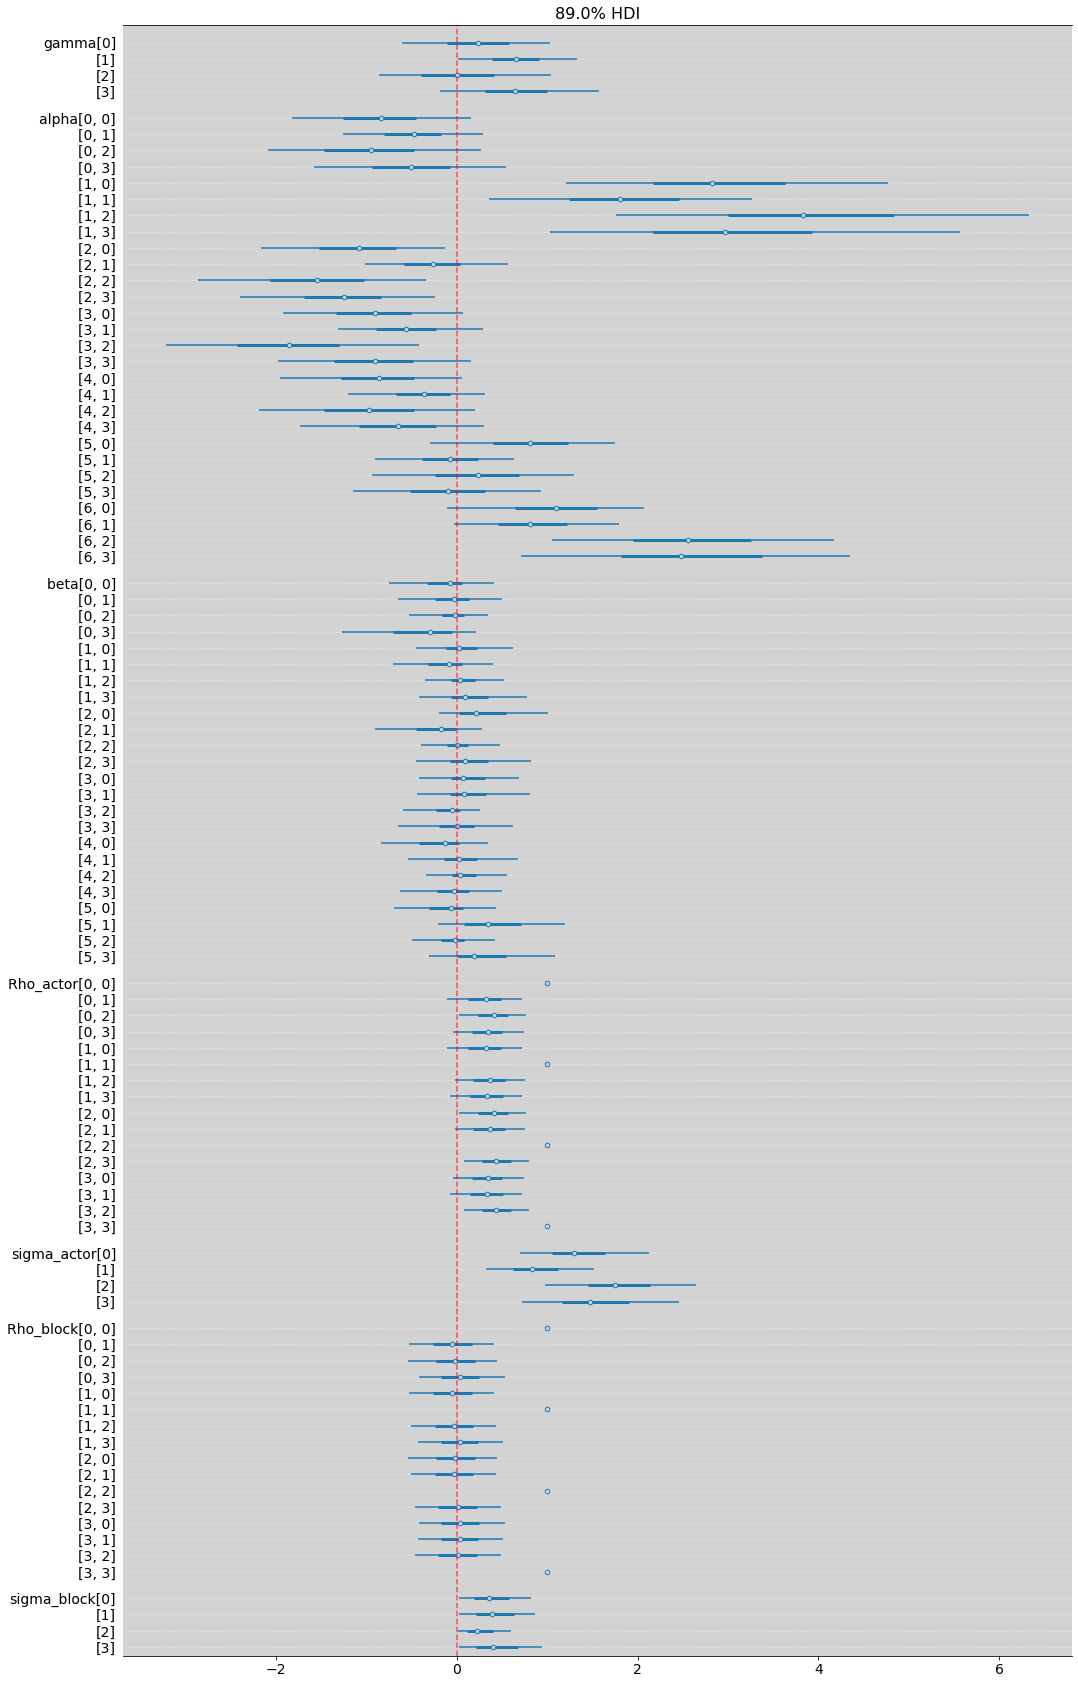

In [44]:
az.plot_forest(m_14_2, hdi_prob=0.89, combined=True, figsize=(17, 30))
plt.grid(axis='y', ls='--', color='white', alpha=0.3)
plt.axvline(x=0, color='red', ls='--', alpha=0.6)
plt.show()

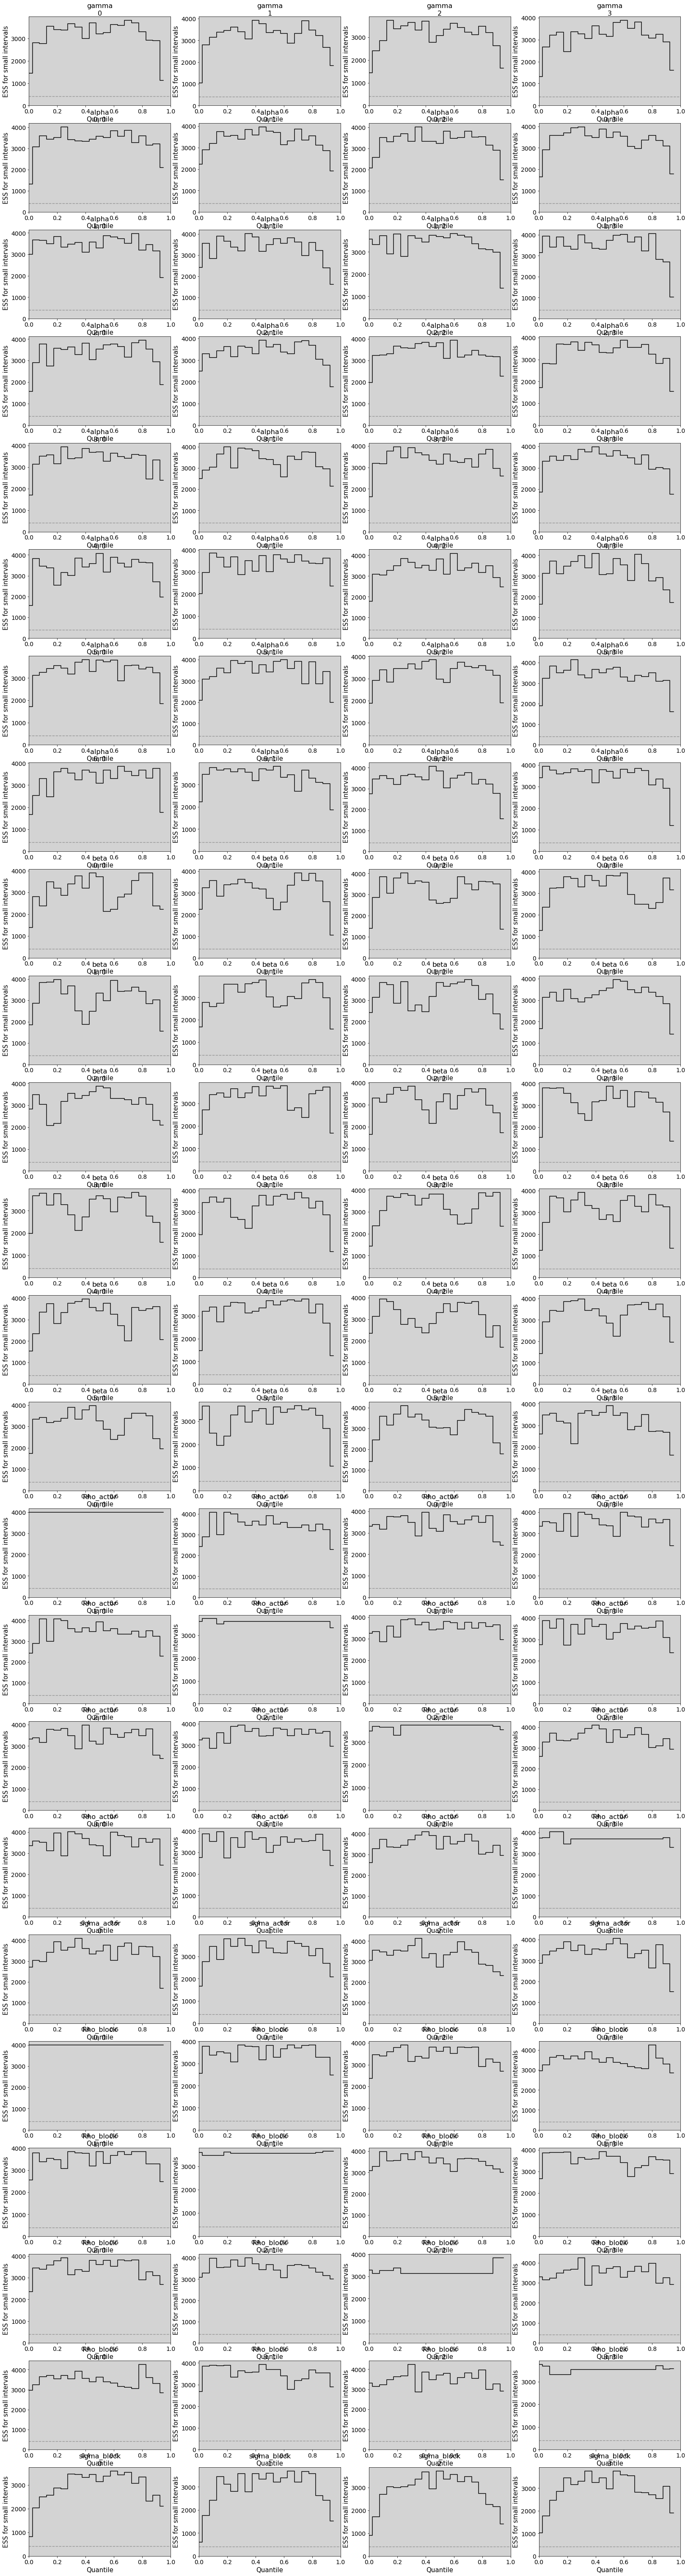

In [45]:
# Like trankplot in this book

az.rcParams['plot.max_subplots'] = 100

az.plot_ess(
    m_14_2, kind="local", drawstyle="steps-mid", color="k",
    linestyle="-", marker=None
)
plt.show()

### R Code 14.19

In [46]:
# Undertanding Cholesky
rho_test = 0.3
R_test = np.matrix([[1, rho_test], [rho_test, 1]])
R_test

matrix([[1. , 0.3],
        [0.3, 1. ]])

In [47]:
# Cholesky decomposition
cholesky_matrix_L = np.linalg.cholesky(R_test)
cholesky_matrix_L

matrix([[1.       , 0.       ],
        [0.3      , 0.9539392]])

In [48]:
# Testing that R=LL^t
cholesky_matrix_L * np.transpose(cholesky_matrix_L)

matrix([[1. , 0.3],
        [0.3, 1. ]])

In [49]:
sample_uncorrelated_z_score = np.random.normal(0, 1, [2,200]) # ?
np.corrcoef(sample_uncorrelated_z_score)

array([[ 1.        , -0.15506489],
       [-0.15506489,  1.        ]])

#### How this model is works?

To understanding the chunck of code below.

```
    transformed parameters{
        matrix[qty_treatments, qty_chimpanzees] alpha;
        matrix[qty_treatments, qty_blocks] beta;
        
        alpha = (diag_pre_multiply(sigma_actor, L_Rho_actor) * z_actor)';
        beta = (diag_pre_multiply(sigma_block, L_Rho_block) * z_block)';   
    }
```

*  PS: $qty\_actor$ *is equal to* $qty\_chimpanzees$ *for this example!* 

**Firts, thinking about matrices dimensions:**

To z's ($z_{anything}$)
- `z_actor`: $[qty\_treatment, qty\_actor]$
- `z_block`: $[qty\_treatment, qty\_block]$


To sigmas ($\sigma$):

- `sigma_actor`: $\sigma_{_{ACTOR}}[qty\_treatments]$
- `sigma_block`: $\sigma_{_{BLOCK}}[qty\_treatments]$


To Rho's ($\rho$):

- `L_Rho_actor`: $\rho_{_{ACTOR}}[qty\_treatments \times qty\_treatments]$
- `L_Rho_block`: $\rho_{_{BLOCK}}[qty\_treatments \times qty\_treatments]$

**Now, understanding the stan functions:**

The Stan function `diag_pre_multiply` [works](https://mc-stan.org/docs/functions-reference/dot-products-and-specialized-products.html):

- `matrix diag_pre_multiply(vector v, matrix m)`

    Return the product of the diagonal matrix formed from the vector `v` and the matrix `m`, i.e., `diag_matrix(v) * m`.
    

The Stan function `diag_matrix(v)` [works](https://mc-stan.org/docs/functions-reference/diagonal-matrix-functions.html):

- `matrix diag_matrix(vector x)`

    The diagonal matrix with diagonal x.
 
For example: $x = \begin{bmatrix}
0.25 \\
0.30 \\
0.25 \\
0.20
\end{bmatrix}$ then `diag_matrix(x)` is equal $\begin{bmatrix}
0.25 & 0 & 0 & 0 \\
0 & 0.30 & 0 & 0 \\
0 & 0 & 0.25 & 0 \\
0 & 0 & 0 & 0.20
\end{bmatrix}$, this is a $[4 \times 4]$ matrix.
 
**Finally, understanding dimensions for alpha and beta:**

Then, this `diag_pre_multiply(sigma_actor, L_Rho_actor)` is:

- `diag_matrix(sigma_actor)` $\times$ `L_Rho_actor`
    $[qty\_treatments \times qty\_treatments] \times [qty\_treatments \times qty\_treatments] = [qty\_treatments \times qty\_treatments]$
    
The complete calculations, have this dimension:

- `(diag_pre_multiply(sigma_actor, L_Rho_actor) * z_actor)`

    $[qty\_treatments \times qty\_treatments] \times [qty\_treatments \times qty\_chimpanzees] = 
[qty\_treatments \times qty\_chimpanzees]$ 
    
And to finish, transpose the matrix ( ' ):
- `(diag_pre_multiply(sigma_actor, L_Rho_actor) * z_actor)'` 

    $[qty\_chimpanzees \times qty\_treatments]$
    
    
Each of the index in matrix above, is a prior to alpha (or beta) in the model. Make the model with this structure is not need using the `multi_normal()`, like the previous model `m_14_2`.
    
    
#### why this model is works? 
(*Complete explanation in book, pg 453.*)

First, the correlation matrix $L$ is a **Cholesky Decomposition** matrix (`cholesky_factor_corr`). This decompostion represent the square and symmetric matrix like a correlation matrix **R**, sucj that $R=LL^T$.

Hence, we can multiply the $L$ by a matrix uncorrelated samples (*z-scores*) and end up with a matrix of correlated samples (the varing effects). This trick allow us to create the correlation matrix out of the prior.

We just sample a matrix of uncorrelated *z-scores* and them multiply those by *Cholesky factor* and the *standart deviation*, hence, we will get the varing effects with the correct scale and correlation. *Not magic, is math!*

The function `diag_pre_multiply(vector a, matrix b)` just build a diagonal square matrix with vector `a`, in this case sigma vector, and multiply by cholesky matrix `b`. **This function produce the correct covariance matrix**. *Awesome, hein!* 

Finally, we multiply this by the matrix *z-score*. This step is like return from standartize parameters.

We just transpose, using `'`, to make `alpha[effect, actor]` to `alpha[actor, effect]`.


In [50]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters{
        vector[qty_treatments] gamma;
        
        matrix[qty_treatments, qty_chimpanzees] z_actor;
        cholesky_factor_corr[qty_treatments] L_Rho_actor;
        vector<lower=0>[qty_treatments] sigma_actor;
        
        matrix[qty_treatments, qty_blocks] z_block;
        cholesky_factor_corr[qty_treatments] L_Rho_block;
        vector<lower=0>[qty_treatments] sigma_block;
    }
    
    transformed parameters{
        matrix[qty_chimpanzees, qty_treatments] alpha;
        matrix[qty_blocks, qty_treatments] beta;
        
        alpha = (diag_pre_multiply(sigma_actor, L_Rho_actor) * z_actor)';  // matrix[qty_actors, qty_treatments]
        beta = (diag_pre_multiply(sigma_block, L_Rho_block) * z_block)';   // Above explanations about this part
    }
    
    model {
        vector[N] p;
    
        // Adaptative Priors - Non-centered
        gamma ~ normal(0, 1);
    
        to_vector(z_actor) ~ normal(0, 1);
        L_Rho_actor ~ lkj_corr_cholesky(2);
        sigma_actor ~ exponential(1);
        
        to_vector(z_block) ~ normal(0, 1);
        L_Rho_block ~ lkj_corr_cholesky(2);
        sigma_block ~ exponential(1);
        
        // Linear model
        for (i in 1:N){
            p[i] = gamma[ treatment[i] ] + alpha[ actor[i], treatment[i] ] + beta[ block[i], treatment[i] ];
            p[i] = inv_logit(p[i]);  // Link function
        }
    
    
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
 
"""


dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  55% (4400/8000)
Sampling:  71% (5700/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.00016 seconds
  1000 transitions using 10 leapfrog steps per tran

In [51]:
 m_14_3 = az.from_pystan(
     posterior=samples,
     posterior_model=posteriori,
     observed_data=dat_list.keys()
 )

In [52]:
print(az.summary(m_14_3, hdi_prob=0.89).to_string())

/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/rodolpho/Projects/

                    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
gamma[0]           0.203  0.511    -0.654      0.947      0.010    0.007    2403.0    2775.0    1.0
gamma[1]           0.638  0.404     0.014      1.299      0.007    0.005    3323.0    3039.0    1.0
gamma[2]          -0.023  0.581    -0.940      0.900      0.010    0.008    3315.0    3029.0    1.0
gamma[3]           0.673  0.546    -0.155      1.566      0.009    0.007    3780.0    2933.0    1.0
z_actor[0, 0]     -0.636  0.468    -1.395      0.079      0.009    0.006    2710.0    2826.0    1.0
z_actor[0, 1]      2.330  0.688     1.270      3.460      0.011    0.008    3791.0    2988.0    1.0
z_actor[0, 2]     -0.850  0.495    -1.654     -0.066      0.010    0.007    2517.0    3219.0    1.0
z_actor[0, 3]     -0.709  0.489    -1.464      0.086      0.009    0.006    2828.0    3315.0    1.0
z_actor[0, 4]     -0.634  0.470    -1.418      0.057      0.009    0.006    2740.0    3066.0    1.0


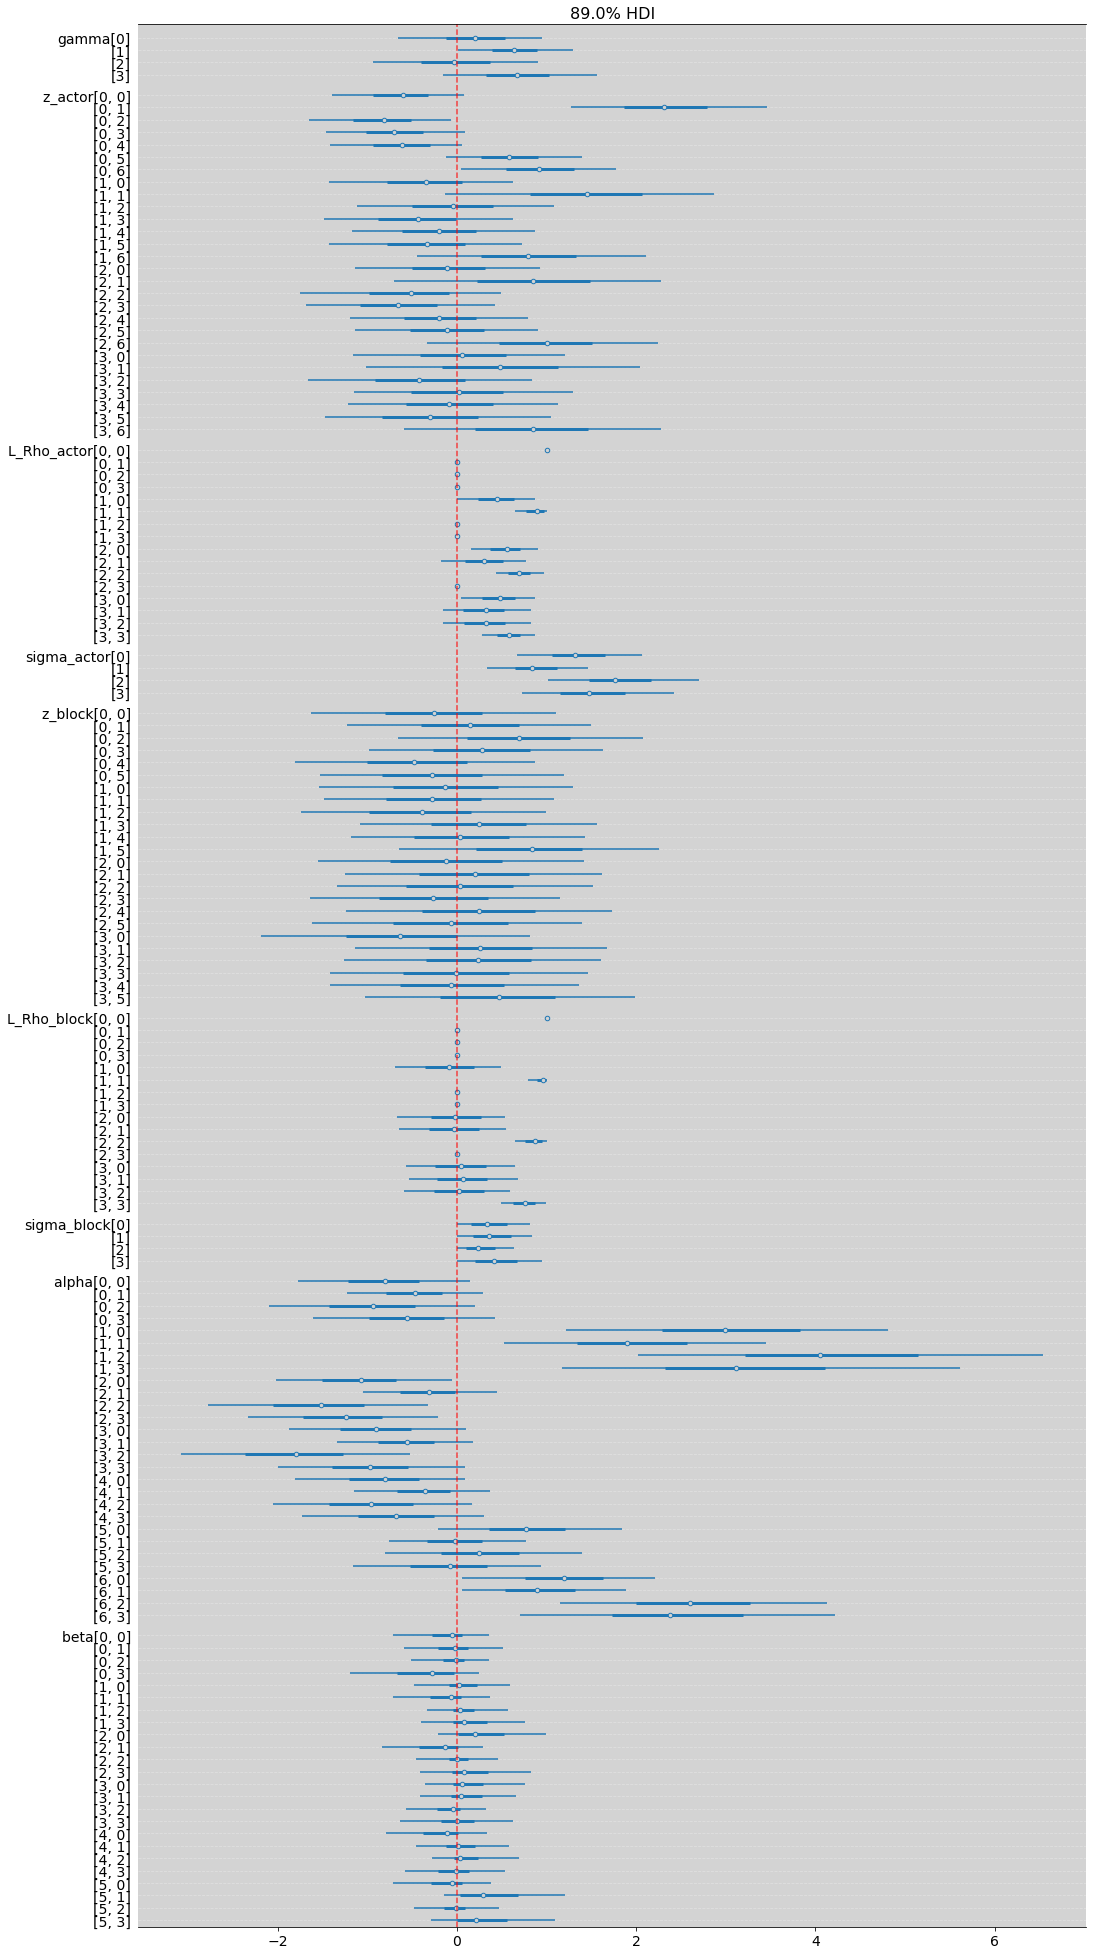

In [53]:
az.plot_forest(m_14_3, combined=True, hdi_prob=0.89, figsize=(17, 35))

plt.axvline(x=0, color='red', ls='--', alpha=0.7)
plt.grid(axis='y', color='white', ls='--', alpha=0.3)

plt.show()

### R Code 14.20

In [54]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

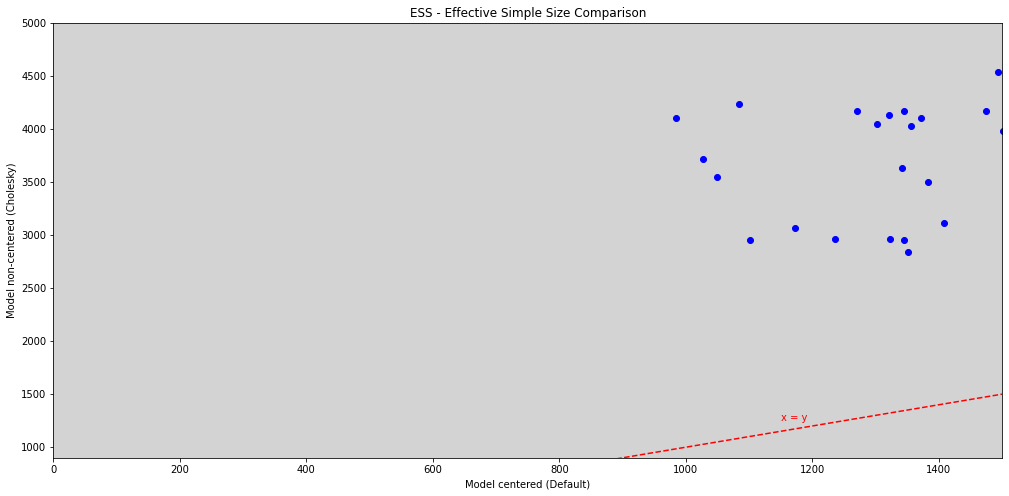

In [55]:
alpha_ess_14_3 = az.ess(m_14_3, var_names=["alpha", "beta"]).alpha.values.flatten()
beta_ess_14_3 = az.ess(m_14_3, var_names=["alpha", "beta"]).alpha.values.flatten()

alpha_ess_14_2 = az.ess(m_14_2, var_names=["alpha", "beta"]).alpha.values.flatten()
beta_ess_14_2 = az.ess(m_14_2, var_names=["alpha", "beta"]).beta.values.flatten()

plt.figure(figsize=(17, 8))

plt.scatter(alpha_ess_14_2, alpha_ess_14_3, c='b')
plt.scatter(beta_ess_14_2, beta_ess_14_3[:24], c='b')

plt.plot([0, 5000], [0, 5000], ls='--', c='red')
plt.text(1150, 1250, 'x = y', color='red')

plt.ylim(900, 5000)
plt.xlim(0, 1500)

plt.title('ESS - Effective Simple Size Comparison')
plt.xlabel('Model centered (Default)')
plt.ylabel('Model non-centered (Cholesky)')

plt.show()

### R Code 14.21

In [56]:
az.summary(m_14_3, var_names=['sigma_actor', 'sigma_block'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_actor[0],1.406,0.499,0.670,2.066,0.010,0.007,2780.0,3033.0,1.0
sigma_actor[1],0.913,0.396,0.334,1.464,0.007,0.005,3112.0,2647.0,1.0
sigma_actor[2],1.872,0.589,1.014,2.698,0.010,0.008,3970.0,2922.0,1.0
sigma_actor[3],1.568,0.587,0.730,2.427,0.011,0.008,2840.0,3003.0,1.0
sigma_block[0],0.403,0.320,0.000,0.814,0.007,0.005,2049.0,2451.0,1.0
sigma_block[1],0.427,0.328,0.000,0.836,0.007,0.005,1959.0,2315.0,1.0
sigma_block[2],0.305,0.276,0.000,0.634,0.004,0.003,3125.0,2689.0,1.0
sigma_block[3],0.482,0.373,0.000,0.947,0.007,0.005,2181.0,2035.0,1.0


### R Code 14.22

In [57]:
# Like R Code 11.17
# ==================

TODO = """
plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    alpha_chimp = az.extract(samples_chimpanzees.posterior.alpha.sel(alpha_dim_0=i)).alpha.values
    
    RN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)).beta.values)
    LN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values)
    RP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)).beta.values)
    LP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values)
    
    # To R/N and R/P
    # ===============
    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN.mean(), RP.mean()], color='black')
    
    # Plot hdi compatibility interval
    RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
    RP_hdi_min, RP_hdi_max = az.hdi(RP, hdi_prob=0.89)
    plt.plot([0.2 + i, 0.2 + i], [RN_hdi_min, RN_hdi_max], c='black')
    plt.plot([0.8 + i, 0.8 + i], [RP_hdi_min, RP_hdi_max], c='black')
    
    # Plot points
    plt.plot(0.2 + i, RN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.8 + i, RP.mean(), 'o', markerfacecolor='black', color='white')
    
    # To L/N and L/P
    # ===============
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN.mean(), LP.mean()], color='black', linewidth=3)

    # Plot hdi compatibility interval
    LN_hdi_min, LN_hdi_max = az.hdi(LN, hdi_prob=0.89)
    LP_hdi_min, LP_hdi_max = az.hdi(LP, hdi_prob=0.89)
    plt.plot([0.3 + i, 0.3 + i], [LN_hdi_min, LN_hdi_max], c='black')
    plt.plot([0.9 + i, 0.9 + i], [LP_hdi_min, LP_hdi_max], c='black')

    plt.plot(0.3 + i, LN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.9 + i, LP.mean(), 'o', markerfacecolor='black', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.08, y=RN.mean() - 0.08, s='R/N')
        plt.text(x=0.68, y=RP.mean() - 0.08, s='R/P')
        plt.text(x=0.17, y=LN.mean() + 0.08, s='L/N')
        plt.text(x=0.77, y=LP.mean() + 0.08, s='L/P')
    
plt.title('Posterior Predictions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()
"""

# TODO: Rebuild to this example. 

## 14.3 Instrumental and Causal Designs

The variable $^*U$ is an unobserved. 

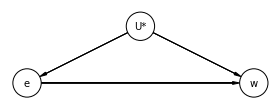

In [58]:
dag_14_3_1 = CausalGraphicalModel(
    nodes=['e', 'U*', 'w'],
    edges=[
        ('U*', 'e'),
        ('U*', 'w'),
        ('e', 'w')
    ],
)

# Drawing the DAG
pgm = daft.PGM()
coordinates = {
    "U*": (2, 1),
    "e": (0, 0),
    "w": (4, 0),
}
for node in dag_14_3_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_14_3_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

plt.show()

Now, we add *Instrumental Variable* **Q**:

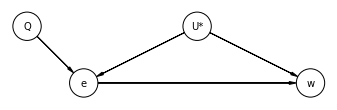

In [59]:
dag_14_3_1 = CausalGraphicalModel(
    nodes=['e', 'U*', 'w', 'Q'],
    edges=[
        ('U*', 'e'),
        ('U*', 'w'),
        ('e', 'w'),
        ('Q', 'e')
    ],
)

# Drawing the DAG
pgm = daft.PGM()
coordinates = {
    "U*": (3, 1),
    "e": (1, 0),
    "w": (5, 0),
    "Q": (0, 1),
}
for node in dag_14_3_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_14_3_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

plt.show()

### R Code 14.23

In [60]:
def standartize(data, get_parameters=False):
    mean = np.mean(data)
    std = np.std(data)
    
    if not get_parameters:
        return list((data - mean)/std)
    else:
        return list((data - mean)/std), mean, std

In [61]:
N = 500

U_sim = np.random.normal(0, 1, N)
Q_sim = np.random.choice([1,2,3,4], size=N, replace=True)

E_sim = np.random.normal(U_sim + Q_sim, 1, N)  # E is influencied by U and Q
W_sim = np.random.normal(U_sim + 0*E_sim, 1, N)  # W is influencied only by U, not by E

dat_sim = pd.DataFrame({
    'W': standartize(W_sim),
    'E': standartize(E_sim),
    'Q': standartize(Q_sim)
})

dat_sim

,W,E,Q
0,0.458919,-1.050410,-1.412495
1,0.367655,0.827180,1.390074
2,-0.058669,0.095503,0.455884
3,0.139368,1.715983,0.455884
4,1.289500,1.171285,0.455884
...,...,...,...
495,-1.661304,0.222796,0.455884
496,0.078534,0.363780,0.455884
497,-0.341889,-1.104266,-1.412495
498,0.326049,-1.023097,-0.478305


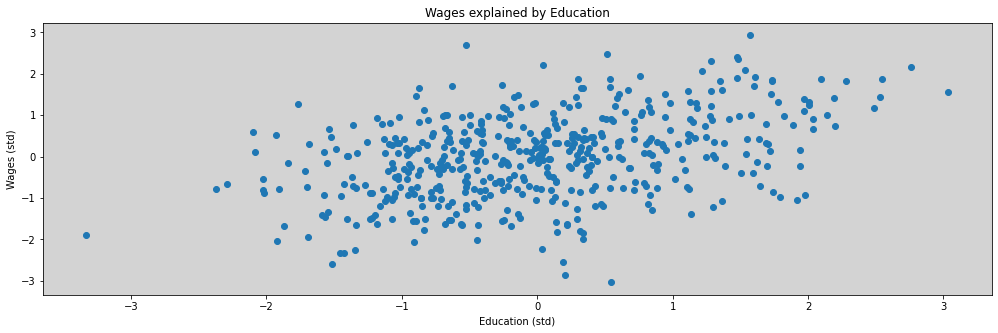

In [62]:
plt.figure(figsize=(17,5))

plt.plot(dat_sim.E, dat_sim.W, 'o')

plt.title('Wages explained by Education')
plt.xlabel('Education (std)')
plt.ylabel('Wages (std)')

plt.show()

In [63]:
model = """
    data {
        int N;
        array[N] real W;
        array[N] real E;
    }
    
    parameters {
        real aW;
        real bEW;
        real<lower=0> sigma;
    }
    
    model {
        array[N] real mu;
        
        aW ~ normal(0, 0.2);
        bEW ~ normal(0, 0.5);
        
        sigma ~ exponential(1);
        
        for (i in 1:N){
            mu[i] = aW + bEW*E[i];
        }
        
        W ~ normal(mu, sigma);
    }

"""

dat_list = {
    'N': len(dat_sim),
    'W': dat_sim.W.values,
    'E': dat_sim.E.values,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_c0jh6dxp/model_52bfqcfx.stan', line 26, column 8 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

In [64]:
model_14_4 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [65]:
az.summary(model_14_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.001,0.040,-0.066,0.061,0.001,0.001,3887.0,3079.0,1.0
bEW,0.414,0.042,0.348,0.480,0.001,0.000,3843.0,2844.0,1.0
sigma,0.912,0.030,0.866,0.960,0.000,0.000,4088.0,3038.0,1.0


### R Code 14.25

In [66]:
model = """
    data {
        int N;
        array[N] real W;
        array[N] real E;
        array[N] real Q;
    }
    
    parameters {
        real aW;
        real bEW;
        real bQW;
        real<lower=0> sigma;
    }
    
    model {
        array[N] real mu;
        
        aW ~ normal(0, 0.2);
        bEW ~ normal(0, 0.5);
        bQW ~ normal(0, 0.5);
        
        sigma ~ exponential(1);
        
        for (i in 1:N){
            mu[i] = aW + bEW*E[i] + bQW*Q[i];
        }
        
        W ~ normal(mu, sigma);
    }

"""

dat_list = {
    'N': len(dat_sim),
    'W': dat_sim.W.values,
    'E': dat_sim.E.values,
    'Q': dat_sim.Q.values,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  12% (1000/8000)
Sampling:  20% (1600/8000)
Sampling:  45% (3600/8000)
Sampling:  65% (5200/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000193 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000122 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!


In [67]:
model_14_5 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [68]:
az.summary(model_14_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.001,0.038,-0.062,0.061,0.001,0.001,4102.0,2682.0,1.0
bEW,0.629,0.049,0.550,0.705,0.001,0.001,3219.0,2919.0,1.0
bQW,-0.345,0.050,-0.426,-0.269,0.001,0.001,3290.0,2899.0,1.0
sigma,0.871,0.027,0.829,0.914,0.000,0.000,3870.0,2771.0,1.0


Include instrument variable $Q$, the bias increase. The `bEW` now is $0.6$ instead of $0.4$ from previous model. The results from the new model is *terrible*! 

Now, we goes to use *instrument variable* correctly.

Let's wirter  four models, simples generative versions of the DAG's. 

1. The firt model for how wages $W$ are caused by education $E$ and the unobserverd confound $U$.

$$ W_i \sim Normal(\mu_{w,i}, \sigma_{w})$$

$$ \mu_{w, i} = \alpha_{w} + \beta_{EW}E_i + U_i $$


2. The second model, for education levels $E$ are caused by quarter of birth $Q$ and the same unobserved confound $U$.

$$ E_i \sim Normal(\mu_{E, i}, \sigma_E) $$

$$ \mu_{E, i} = \alpha_{E} + \beta_{QE}Q_i + U_i $$

3. The thirt model is for $Q$, that says that one-quarter of all people born in each quarter of the year.

$$ Q_i \sim Categorical([0.25, 0.25, 0.25, 0.25]) $$

4. Finally, the model says that the unobserved confound $U$ is normally distributed with mean standart gaussian.

$$ U_i \sim Normal(0, 1) $$

Now, we writer this generative model to statistical model, like multivariate normal distribution. Like this:

$$\begin{pmatrix}
W_i \\
E_i
\end{pmatrix} \sim
 MVNormal\begin{pmatrix}
 \begin{bmatrix}
 \mu_{w, i} \\
 \mu_{E, i}
 \end{bmatrix}, S
 \end{pmatrix}
$$